## 1. Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.metrics import silhouette_score , silhouette_samples, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import plotly.express as px
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set random seed untuk reprodusibilitas
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Dataset

Dataset diambil dari GitHub repository sesuai ketentuan kompetisi.

In [2]:
# Load dataset
url = 'https://raw.githubusercontent.com/micelll/SPARC-2026/main/SPARC_dataset.csv'
df = pd.read_csv(url)
df.head()

,Customer ID,Kelurahan,Kecamatan,Kode POS,Cash/Credit,Kode Dealer,Finance Company,Tenor,Gender,Tgl Lahir,...,range dp,wilayah,9 segment,kode motor,OTR,tahun rakit,DLR group,tgl cetak,tgl mohon,Kode Kota-Provinsi
0,CUST-159769,Baru Ilir,Balikpapan Barat,76131,2.0,12756.0,4,3,2,1992-03-03 0:00:00,...,2 - 3 juta,6471,AT LOW,HN,18685000.0,NaN,NaN,NaN,02-01-2019,6471-6400
1,CUST-164551,BARU TENGAH,BALIKPAPAN BARAT,76132,2.0,733.0,1,1,2,1991-04-27 0:00:00,...,3 jt up,6471,AT LOW,HN,18685000.0,NaN,NaN,NaN,02012019,6471-6400
2,CUST-159733,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1982-01-04 0:00:00,...,kurang 1 juta,6471,AT MID,HR,20775000.0,NaN,NaN,NaN,02012019,6471-6400
3,CUST-164422,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1997-06-26 0:00:00,...,krg 1 jt,6471,AT MID,HR,20775000.0,NaN,NaN,NaN,02012019,6471-6400
4,CUST-155472,Baru Ulu,Balikpapan Barat,76133,2.0,11160.0,1,2,1,1996-07-12 0:00:00,...,2 - 3 jt,6471,AT MID,HR,20775000.0,NaN,NaN,NaN,02-01-2019,6471-6400


a

In [3]:
# Informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319978 entries, 0 to 319977
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Customer ID         319964 non-null  object 
 1   Kelurahan           319962 non-null  object 
 2   Kecamatan           319963 non-null  object 
 3   Kode POS            319963 non-null  object 
 4   Cash/Credit         319963 non-null  float64
 5   Kode Dealer         319963 non-null  float64
 6   Finance Company     319889 non-null  object 
 7   Tenor               319942 non-null  object 
 8   Gender              319962 non-null  object 
 9   Tgl Lahir           319963 non-null  object 
 10  Agama               319963 non-null  object 
 11  Pekerjaan           319963 non-null  object 
 12  umur                319963 non-null  float64
 13  dp aktual           319234 non-null  object 
 14  cicilan             319276 non-null  object 
 15  warna               319963 non-nul

In [4]:
df.isnull().sum()
#cek persentassi mising value
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

Customer ID            0.004375
Kelurahan              0.005000
Kecamatan              0.004688
Kode POS               0.004688
Cash/Credit            0.004688
Kode Dealer            0.004688
Finance Company        0.027814
Tenor                  0.011251
Gender                 0.005000
Tgl Lahir              0.004688
Agama                  0.004688
Pekerjaan              0.004688
umur                   0.004688
dp aktual              0.232516
cicilan                0.219390
warna                  0.004688
dealer                 0.004688
type series            0.004688
range dp               0.004688
wilayah                0.004688
9 segment              0.004688
kode motor             0.016876
OTR                    0.005938
tahun rakit            3.097713
DLR group             80.687110
tgl cetak             95.866591
tgl mohon              0.004375
Kode Kota-Provinsi     0.000000
dtype: float64

In [11]:
# Statistik deskriptif untuk kolom numerik
df.describe()

,Cash/Credit,Kode Dealer,umur,OTR,tgl cetak
count,319963.000000,319963.000000,319963.000000,3.199590e+05,1.322600e+04
mean,1.564146,29590.377194,94.346583,6.541080e+07,1.334797e+07
std,0.495869,44345.496360,134.293311,9.053097e+07,8.308178e+06
min,1.000000,733.000000,0.000000,0.000000e+00,1.042019e+06
25%,1.000000,10412.000000,28.000000,2.117000e+07,6.032019e+06
50%,2.000000,13115.000000,39.000000,2.361500e+07,1.210202e+07
75%,2.000000,16919.000000,53.000000,3.404000e+07,1.908202e+07
max,2.000000,168507.000000,1230.000000,9.301000e+08,3.112202e+07


C:\Users\Fauzan\AppData\Local\Temp\ipykernel_16056\4088799034.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=wilayah_counts.index, x=wilayah_counts.values, palette='viridis', ax=ax)
C:\Users\Fauzan\AppData\Local\Temp\ipykernel_16056\4088799034.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=dealer_counts.index, x=dealer_counts.values, palette='plasma', ax=ax)
C:\Users\Fauzan\AppData\Local\Temp\ipykernel_16056\4088799034.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=kecamatan_counts.index, x=kecamatan_counts.values, pal

C:\Users\Fauzan\AppData\Local\Temp\ipykernel_16056\4088799034.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=wilayah_counts.index, x=wilayah_counts.values, palette='viridis', ax=ax)
C:\Users\Fauzan\AppData\Local\Temp\ipykernel_16056\4088799034.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=dealer_counts.index, x=dealer_counts.values, palette='plasma', ax=ax)
C:\Users\Fauzan\AppData\Local\Temp\ipykernel_16056\4088799034.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=kecamatan_counts.index, x=kecamatan_counts.values, pal

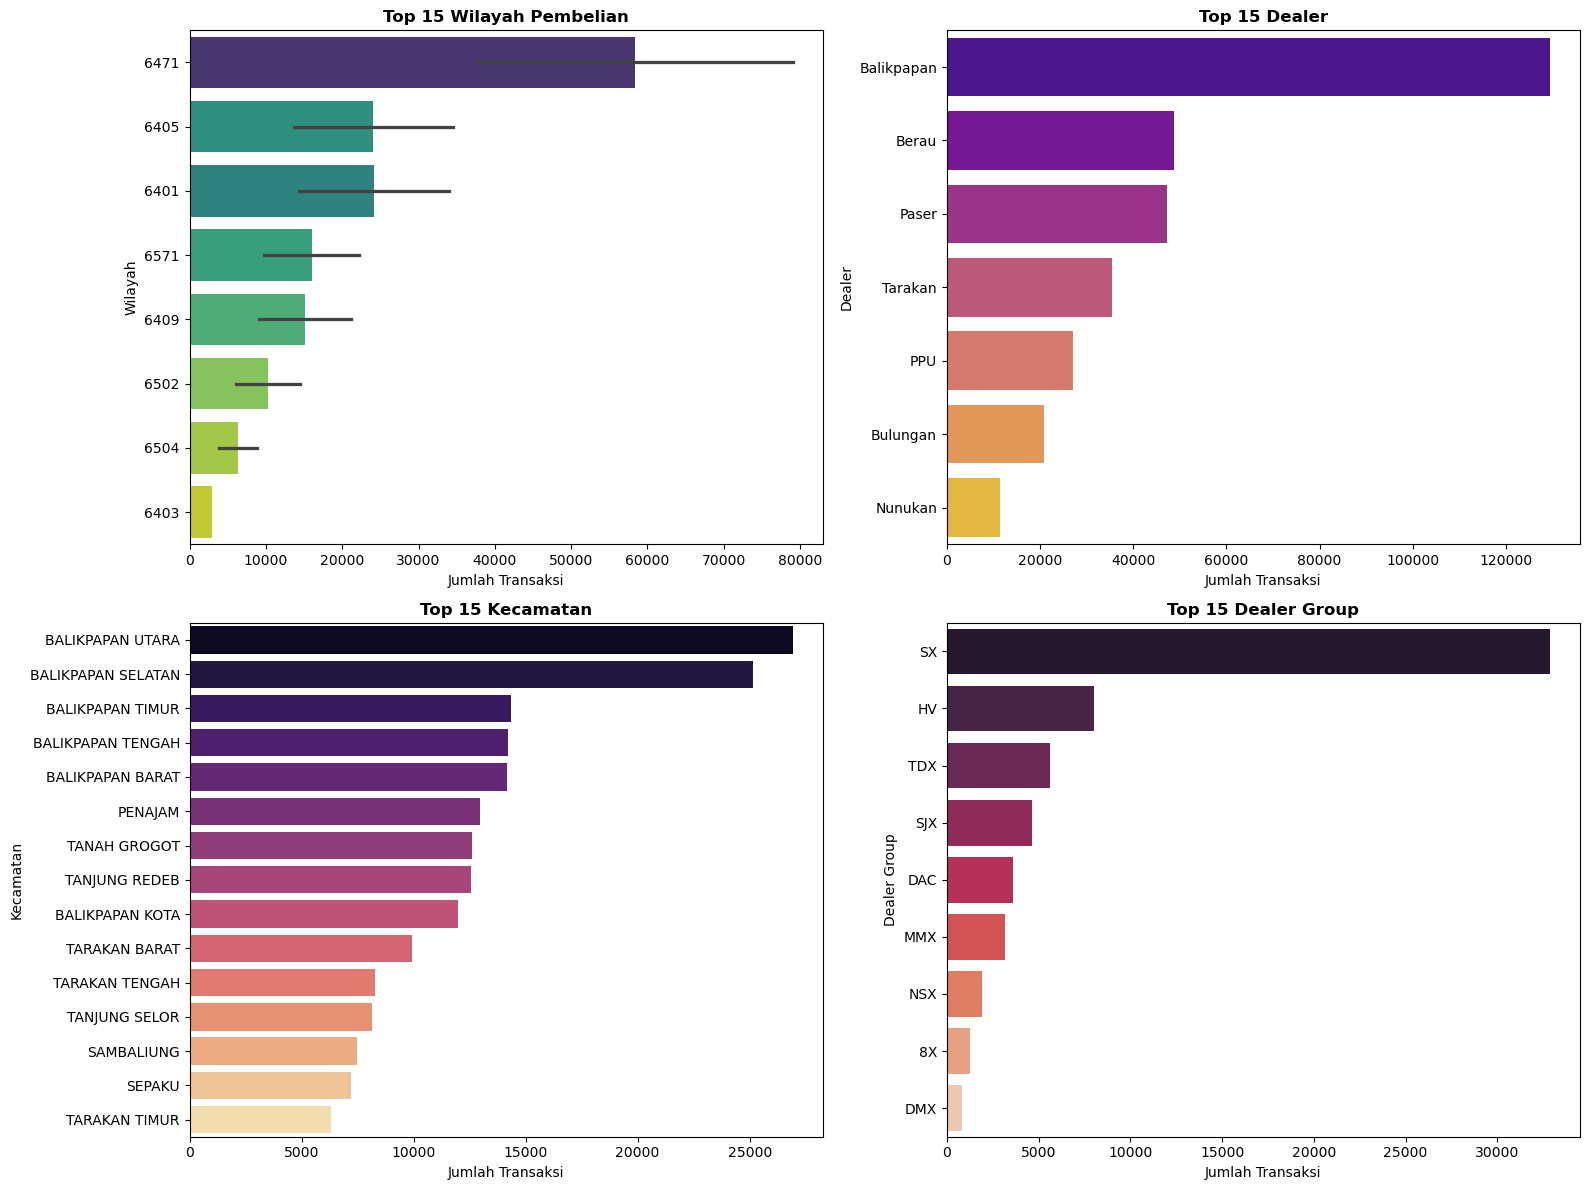


✓ Visualisasi analisis geografis berhasil ditampilkan


In [19]:
# Analisis geografis: Wilayah, Dealer, Kecamatan
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 15 Wilayah
if 'wilayah' in df.columns:
    wilayah_counts = df['wilayah'].value_counts().head(15)
    ax = axes[0, 0]
    sns.barplot(y=wilayah_counts.index, x=wilayah_counts.values, palette='viridis', ax=ax)
    ax.set_title('Top 15 Wilayah Pembelian', fontsize=12, fontweight='bold')
    ax.set_xlabel('Jumlah Transaksi')
    ax.set_ylabel('Wilayah')

# 2. Top 15 Dealer
if 'dealer' in df.columns:
    dealer_counts = df['dealer'].value_counts().head(15)
    ax = axes[0, 1]
    sns.barplot(y=dealer_counts.index, x=dealer_counts.values, palette='plasma', ax=ax)
    ax.set_title('Top 15 Dealer', fontsize=12, fontweight='bold')
    ax.set_xlabel('Jumlah Transaksi')
    ax.set_ylabel('Dealer')

# 3. Top 15 Kecamatan
if 'Kecamatan' in df.columns:
    kecamatan_counts = df['Kecamatan'].value_counts().head(15)
    ax = axes[1, 0]
    sns.barplot(y=kecamatan_counts.index, x=kecamatan_counts.values, palette='magma', ax=ax)
    ax.set_title('Top 15 Kecamatan', fontsize=12, fontweight='bold')
    ax.set_xlabel('Jumlah Transaksi')
    ax.set_ylabel('Kecamatan')

# 4. DLR Group Distribution
if 'DLR group' in df.columns:
    dlr_counts = df['DLR group'].value_counts().head(15)
    ax = axes[1, 1]
    sns.barplot(y=dlr_counts.index, x=dlr_counts.values, palette='rocket', ax=ax)
    ax.set_title('Top 15 Dealer Group', fontsize=12, fontweight='bold')
    ax.set_xlabel('Jumlah Transaksi')
    ax.set_ylabel('Dealer Group')

plt.tight_layout()
plt.show()

print("\n✓ Visualisasi analisis geografis berhasil ditampilkan")